
This notebook was created for testing different methods, models, or hyperparameter settings as part of the project.  
It was **not used directly** in the final application, but served for performance comparison, experimentation, and exploration of alternatives.  
The results may be referenced in the report, but the model generated here was **not deployed**.

In [1]:
# Importing all the necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
# import keras_metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.
c:\Users\akadi\anaconda3\envs\tf1env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\akadi\anaconda3\envs\tf1env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\akadi\anaconda3\envs\tf1env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\akadi\anaconda3\envs\tf1env\lib\sit

In [2]:
# Storing directory of glove embeddings
#GLOVE_DIR = "E:\MSc DA\Sem 2\Project\Code and Docmentation\glove.6B"
#EMBEDDING_DIM = 50

GLOVE_DIR = r"C:\Users\akadi\Desktop\Bitirme\Code\glove.6B"
EMBEDDING_DIM = 50

# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)
    return x

def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [3]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [4]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [5]:
# Creating vocabulary with glove embeddings
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [6]:
# Creating word index
word_index = tokenizer.word_index
num_tokens = len(word_index)

#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

In [8]:
# Defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# Defining embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm1 = LSTM(32, return_state=True)
encoder_outputs,state_h,state_c = (lstm1)(embedded_sequences)
states= [state_h,state_c]

In [9]:
# Defining second LSTM
lstm2=LSTM(32, return_sequences=True, return_state=True)
# Adding initial state as state of  previous LSTM
decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
# Adding dense layer with 500 neurons
decoder_dense = (Dense(500, activation='relu'))
# LSTM output
lstm_out=(decoder_out)
# Flattening 
lstm_out = Flatten()(lstm_out)
# Output of text model
txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [10]:
# Defining text model
txt_model = Model(inputs = [main_input], outputs=txt_out)
# compiling text model
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
from keras.utils import plot_model
# Plotting the text model

txt_model.summary()    #   Metin modelinin katmanlarını listeler

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 50)     219000      main_input[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 32), (None,  10624       embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1000, 32), ( 10624       embedding_1[0][0]                
                                                                 lstm_1[0][1]                     
          

In [12]:
    # Model tanımı + eğitim
txt_model.fit_generator(txt_gen_train, epochs=10, validation_steps = 149, steps_per_epoch=5,
                        validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/10
5/5 [==============================] - 28s 6s/step - loss: 0.8049 - acc: 0.4500 - val_loss: 0.6758 - val_acc: 0.5973
Epoch 2/10
5/5 [==============================] - 24s 5s/step - loss: 0.8205 - acc: 0.5938 - val_loss: 0.6784 - val_acc: 0.5973
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 0.8022 - acc: 0.5875 - val_loss: 0.7143 - val_acc: 0.4027
Epoch 4/10
5/5 [==============================] - 24s 5s/step - loss: 0.7982 - acc: 0.3813 - val_loss: 0.7028 - val_acc: 0.4295
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 0.7977 - acc: 0.5563 - val_loss: 0.6848 - val_acc: 0.6107
Epoch 6/10
5/5 [==============================] - 25s 5s/step - loss: 0.7921 - acc: 0.6562 - val_loss: 0.6908 - val_acc: 0.5302
Epoch 7/10
5/5 [==============================] - 25s 5s/step - loss: 0.7731 - acc: 0.6688 - val_loss: 0.6808 - val_acc: 0.6174
Epoch 8/10
5/5 [==============================] - 25s 5s/step - loss: 0.7931 - acc: 0.6688 - val_loss: 0

In [13]:
# Saving text model (option)
txt_model.save('Stack_LSTM_txt_model.h5')


c:\Users\akadi\anaconda3\envs\tf1env\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [14]:
# Predicting labels of the test set
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
# Defining true labels
y_true = y_test.values

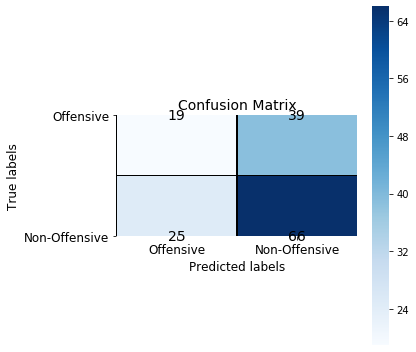

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix hesapla
labels = [1, 0]
cm = confusion_matrix(y_true, y_pred_txt, labels)

# Çizim
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

# Başlık ve etiketler
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Eksen etiketleri (manuel yerleştirme)
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=12)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [16]:
# 1. Gerekli kütüphaneler
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Training_path = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Training_meme_dataset.csv"
Validation_path = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Validation_meme_dataset.csv"
Testing_path = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Split Dataset\Testing_meme_dataset.csv"
img_dir = r"C:\Users\akadi\Desktop\Bitirme\Code\Data\Labelled Images"


# 3. CSV dosyalarını yükle
train_df = pd.read_csv(Training_path)
val_df   = pd.read_csv(Validation_path)
test_df  = pd.read_csv(Testing_path)

# Görsel yollarını oluştur
for df in [train_df, val_df, test_df]:
    df['img_path'] = df['image_name'].apply(lambda x: os.path.join(img_dir, x))

# 4. Label encoding (çok önemli!)
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label']   = le.transform(val_df['label'])
test_df['label']  = le.transform(test_df['label'])

# 5. Görselleri yükleme fonksiyonu
def load_images(paths):
    images = []
    for path in paths:
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

# 6. Verileri numpy'a çevir
X_train = load_images(train_df['img_path'].values)
y_train = train_df['label'].values

X_val   = load_images(val_df['img_path'].values)
y_val   = val_df['label'].values

X_test  = load_images(test_df['img_path'].values)
y_test  = test_df['label'].values


In [17]:
# 7. VGG16 modelini oluştur
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # VGG katmanlarını dondur

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

img_model = Model(inputs=base_model.input, outputs=predictions)
img_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



In [18]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
# 8. Eğitimi başlat
img_model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=5,
          batch_size=32,
          shuffle=True)

Train on 445 samples, validate on 149 samples
Epoch 1/5
445/445 [==============================] - 49s 109ms/step - loss: 1.5262 - acc: 0.4854 - val_loss: 1.6107 - val_acc: 0.5235
Epoch 2/5
445/445 [==============================] - 48s 108ms/step - loss: 1.3049 - acc: 0.5034 - val_loss: 1.4990 - val_acc: 0.5302
Epoch 3/5
445/445 [==============================] - 47s 106ms/step - loss: 1.1392 - acc: 0.5213 - val_loss: 1.4366 - val_acc: 0.5369
Epoch 4/5
445/445 [==============================] - 44s 99ms/step - loss: 1.0155 - acc: 0.5506 - val_loss: 1.3747 - val_acc: 0.5436
Epoch 5/5
445/445 [==============================] - 44s 99ms/step - loss: 0.9115 - acc: 0.5730 - val_loss: 1.3271 - val_acc: 0.5369


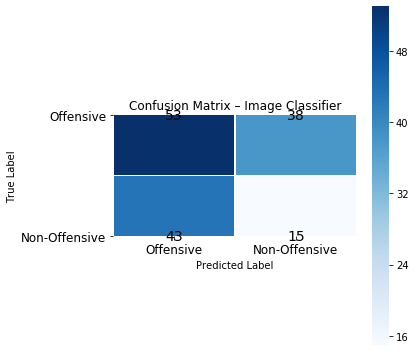

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tahmin ve matris
y_pred = img_model.predict(X_test)
y_pred = np.round(y_pred).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    annot_kws={"color": "black", "size": 14}  # Sayılar siyah ve daha büyük
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Image Classifier")
plt.xticks([0.5, 1.5], ['Offensive', 'Non-Offensive'], fontsize=12)
plt.yticks([0.5, 1.5], ['Offensive', 'Non-Offensive'], fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


In [21]:
# image Modeli kaydet (option)

img_model.save('VGG16_img_model.h5')
 

In [32]:
training_DF['label'].value_counts()
###########################



0    258
1    187
Name: label, dtype: int64

In [22]:
from keras.models import Model
from keras.layers import Dense, concatenate
from keras import optimizers
from keras.optimizers import Adam

# Alt modellerin compile edilmesine gerek yok (com_model ayrı compile edilir)
txt_model.trainable = True
img_model.trainable = True

# Çıktıların birleştirilmesi
con_layer = concatenate([txt_model.output, img_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

# Birleşik model
com_model = Model(inputs=[img_model.input, txt_model.input], outputs=out)

# Optimizer
adam = Adam(lr=0.0001)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])


In [23]:
com_model.fit_generator(
                        img_txt_gen_train,
                        epochs=10,
                        validation_steps=10,
                        steps_per_epoch=10,
                        validation_data=img_txt_gen_val,
                        shuffle=True,
                        class_weight=class_weight)  # varsa kullan, yoksa çıkar



com_model.save('Stack_LSTM_VGG_mul_model.h5')

Epoch 1/10
10/10 [==============================] - 41s 4s/step - loss: 0.8504 - acc: 0.5906 - val_loss: 0.6781 - val_acc: 0.6000
Epoch 2/10
10/10 [==============================] - 38s 4s/step - loss: 0.8357 - acc: 0.5812 - val_loss: 0.6749 - val_acc: 0.6000
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 0.8267 - acc: 0.5906 - val_loss: 0.5997 - val_acc: 0.9000
Epoch 4/10
10/10 [==============================] - 35s 3s/step - loss: 0.8408 - acc: 0.5531 - val_loss: 0.6335 - val_acc: 0.8000
Epoch 5/10
10/10 [==============================] - 38s 4s/step - loss: 0.8312 - acc: 0.5594 - val_loss: 0.6962 - val_acc: 0.5000
Epoch 6/10
10/10 [==============================] - 45s 5s/step - loss: 0.8144 - acc: 0.5875 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 7/10
10/10 [==============================] - 44s 4s/step - loss: 0.8041 - acc: 0.6125 - val_loss: 0.7065 - val_acc: 0.4000
Epoch 8/10
10/10 [==============================] - 44s 4s/step - loss: 0.8069 - acc: 0.60

c:\Users\akadi\anaconda3\envs\tf1env\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


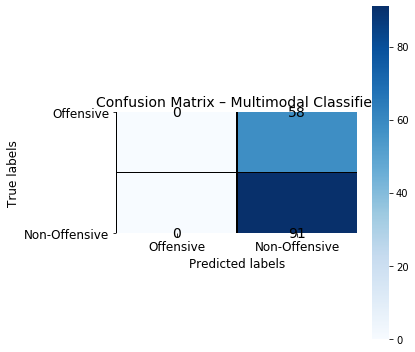

In [24]:
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahmin
y_pred_com = com_model.predict_generator(img_txt_gen_test, steps=149)
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

# Confusion matrix hesapla
labels = [1, 0]
cm = confusion_matrix(y_true, y_pred_com, labels)

# Görsel çizim (geliştirilmiş)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix – Multimodal Classifier', fontsize=14)
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=12)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


In [25]:
#asıl kod
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [26]:
# Concatenating output of both classifiers
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [27]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [28]:
# Using Stochastic gradient descent with optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [29]:
# PlotTing combined model
#plot_model(com_model, to_file='Stack_LSTM_VGG_mul_model.png', show_shapes=True, show_layer_names=True)
com_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [31]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=3,
                         validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
3/3 [==============================] - 45s 15s/step - loss: 0.8059 - acc: 0.4167 - val_loss: 0.7018 - val_acc: 0.4027
Epoch 2/7
3/3 [==============================] - 37s 12s/step - loss: 0.7977 - acc: 0.4583 - val_loss: 0.6960 - val_acc: 0.4430
Epoch 3/7
3/3 [==============================] - 42s 14s/step - loss: 0.8036 - acc: 0.5104 - val_loss: 0.6980 - val_acc: 0.4966
Epoch 4/7
3/3 [==============================] - 37s 12s/step - loss: 0.8121 - acc: 0.4792 - val_loss: 0.6949 - val_acc: 0.4765
Epoch 5/7
3/3 [==============================] - 34s 11s/step - loss: 0.8071 - acc: 0.5312 - val_loss: 0.6962 - val_acc: 0.4430
Epoch 6/7
3/3 [==============================] - 34s 11s/step - loss: 0.8020 - acc: 0.5000 - val_loss: 0.6958 - val_acc: 0.4295
Epoch 7/7
3/3 [==============================] - 34s 11s/step - loss: 0.7993 - acc: 0.4583 - val_loss: 0.7019 - val_acc: 0.4094


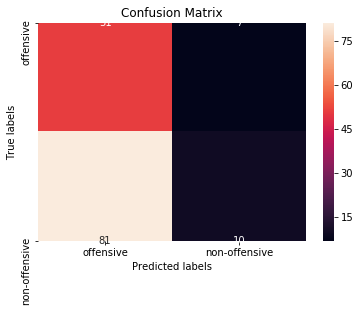

In [32]:
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

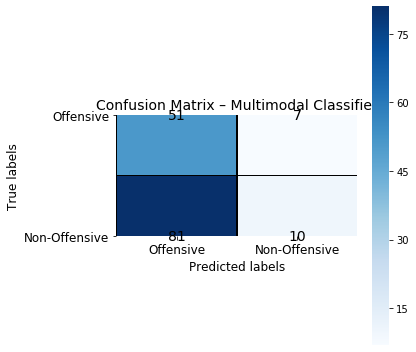

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
labels = [1, 0]
cm = confusion_matrix(y_true, y_pred_com, labels)

# Çizim
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=0.5,
    linecolor='black',
    annot_kws={"color": "black", "size": 14}
)

# Etiketler ve başlık
ax.set_xlabel('Predicted labels', fontsize=12)
ax.set_ylabel('True labels', fontsize=12)
ax.set_title('Confusion Matrix – Multimodal Classifier', fontsize=14)

# Eksen değerlerini elle belirle
ax.set_xticklabels(['Offensive', 'Non-Offensive'], fontsize=12)
ax.set_yticklabels(['Offensive', 'Non-Offensive'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


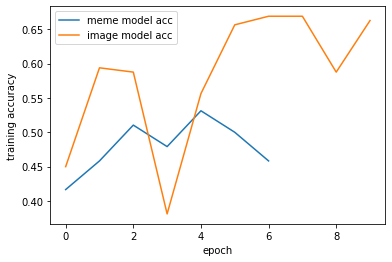

In [34]:
# Plotting training accuaracy 
plt.plot(com_model.history.epoch, com_model.history.history['acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc', 'text model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

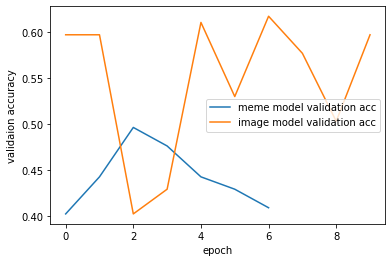

In [35]:
# Plotting validation accuracy
plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc', 'text model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [52]:
# Evaluating model by calculating loss and accuracy respectively
# for combined model
com_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.7969382405281067, 0.6]

In [53]:
# loss and accuracy for text model
txt_model.evaluate_generator(txt_gen_test, steps=5)

[2.20242957418086, 0.6]

In [54]:
# Loss and accuracy for image model
img_model.evaluate_generator(img_gen_test, steps=5)

[12.088058471679688, 0.0]

In [53]:
from sklearn.metrics import precision_recall_fscore_support

In [54]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.60465116, 0.3968254 ]),
 array([0.57777778, 0.42372881]),
 array([0.59090909, 0.40983607]),
 array([90, 59], dtype=int64))

In [58]:
# for image
precision_recall_fscore_support(y_true, y_pred_img, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.608     , 0.41666667]),
 array([0.84444444, 0.16949153]),
 array([0.70697674, 0.24096386]),
 array([90, 59], dtype=int64))

In [59]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.62264151, 0.40625   ]),
 array([0.36666667, 0.66101695]),
 array([0.46153846, 0.50322581]),
 array([90, 59], dtype=int64))